# Finding Heavy Traffic Indicators on I-94
In this project, we are going to analyze a dataset about the westbound traffic on the I-94 Interstate highway. The dataset is available [here](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume). 

The goal of this project is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows.

The dataset documentation mentions that a station located approximately midway between Minneapolis and Saint Paul recorded the traffic data. Also, the station only records westbound traffic (cars moving from east to west). This means that the results of our analysis will be about the westbound traffic in the proximity of that station. In other words, we should avoid generalizing our results for the entire I-94 highway.

In [1]:
# Import all libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
# Read the dataset and get some insight
traffic = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
traffic.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
traffic.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [4]:
traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [5]:
traffic.describe(include='all')

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
count,48204,48204.000000,48204.000000,48204.000000,48204.000000,48204,48204,48204,48204.000000
unique,12,NaN,NaN,NaN,NaN,11,38,40575,NaN
top,None,NaN,NaN,NaN,NaN,Clouds,sky is clear,2013-05-19 10:00:00,NaN
freq,48143,NaN,NaN,NaN,NaN,15164,11665,6,NaN
mean,NaN,281.205870,0.334264,0.000222,49.362231,NaN,NaN,NaN,3259.818355
std,NaN,13.338232,44.789133,0.008168,39.015750,NaN,NaN,NaN,1986.860670
min,NaN,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,0.000000
25%,NaN,272.160000,0.000000,0.000000,1.000000,NaN,NaN,NaN,1193.000000
50%,NaN,282.450000,0.000000,0.000000,64.000000,NaN,NaN,NaN,3380.000000
75%,NaN,291.806000,0.000000,0.000000,90.000000,NaN,NaN,NaN,4933.000000


By just observing the descriptive statistics of the dataset, it is obvious that the 'temp' and 'rain_1h' columns have some outliers. 
* The minimum temperature is 0k. Such a low temperature is not possible on earth. So, it doesn't make sense. 
* Similarly, the mean value of 'rain_1h' column is 0.33mm. But the maximum value is 9831.30mm, which also doesn't make sense. 

Moreover, the date_time column holds non-numeric values. We need to convert them to either date-time object or integer values for future convenience. To get some insight about the the 'traffic_volume' columns, let's plot a histrogram.

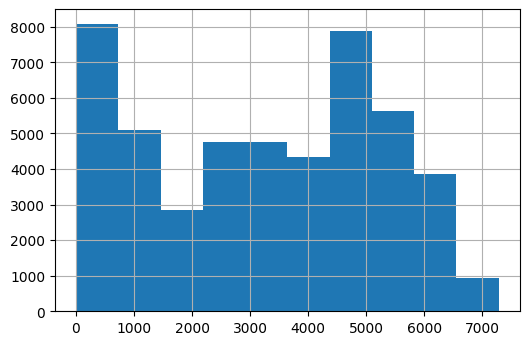

In [6]:
traffic['traffic_volume'].hist()

As we can observe, the nature of the histogram is bimodal. It indicates that either the data has been collected from two different sources or the data can be seperated into two different parts. From descriptive statistics, we know that:
* About 25% of the time, there were 1,193 cars or fewer passing the station each hour — this probably occurs during the night, or when a road is under construction.
* About 25% of the time, the traffic volume was four times as much (4,933 cars or more).

This possibility that nighttime and daytime might influence traffic volume gives our analysis an interesting direction: comparing daytime with nighttime data. For this purpose, we divide the dataset into two parts:

* Daytime data: hours from 7 a.m. to 7 p.m. (12 hours)
* Nighttime data: hours from 7 p.m. to 7 a.m. (12 hours)

First, we transform the `date_time` column to `datetime` for our convenience

In [7]:
traffic['date_time'] = pd.to_datetime(traffic['date_time'])

In [8]:
traffic.head(2)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516


In [9]:
traffic.tail(2)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [10]:
print(traffic['date_time'].dt.hour.head(2))
type(traffic['date_time'].dt.hour)

0     9
1    10
Name: date_time, dtype: int64


pandas.core.series.Series

In [11]:
daytime = traffic.copy()[traffic['date_time'].dt.hour.between(6, 19, inclusive = False)]
nighttime = traffic.copy()[(traffic['date_time'].dt.hour > 18) |
                   (traffic['date_time'].dt.hour < 7)]

print(daytime.head(2)['date_time'])
print(daytime.tail(2)['date_time'])
print(nighttime.head(2)['date_time'])
print(nighttime.tail(2)['date_time'])

0   2012-10-02 09:00:00
1   2012-10-02 10:00:00
Name: date_time, dtype: datetime64[ns]
48197   2018-09-30 17:00:00
48198   2018-09-30 18:00:00
Name: date_time, dtype: datetime64[ns]
10   2012-10-02 19:00:00
11   2012-10-02 20:00:00
Name: date_time, dtype: datetime64[ns]
48202   2018-09-30 22:00:00
48203   2018-09-30 23:00:00
Name: date_time, dtype: datetime64[ns]


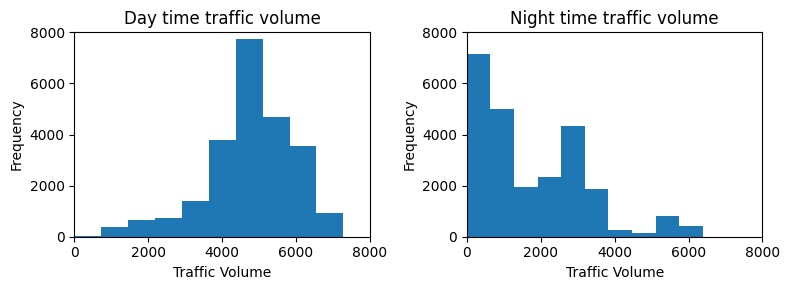

In [12]:
# Plot the histograms of traffic_volume for both day and night
plt.figure(figsize=(8,3))

plt.subplot(1, 2, 1)
plt.hist(daytime['traffic_volume'])
plt.title("Day time traffic volume")
plt.xlabel("Traffic Volume")
plt.ylabel("Frequency")
plt.ylim([0, 8000])
plt.xlim([0, 8000])

plt.subplot(1, 2, 2)
plt.hist(nighttime['traffic_volume'])
plt.title("Night time traffic volume")
plt.xlabel("Traffic Volume")
plt.ylabel("Frequency")
plt.ylim([0, 8000])
plt.xlim([0, 8000])

plt.tight_layout()
plt.show()

From the histogram above, it is obvious that the traffic at night is generally light. Our goal is to find indicators of heavy traffic, so we have decided to only focus on the daytime data moving forward.

One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of the day.

We're going to look at a few line plots showing how the traffic volume changed according to the following parameters:

* Month
* Day of the week
* Time of day

Let's start by getting average traffic volume for each month and generating the line plot.

In [13]:
daytime['month'] = daytime['date_time'].dt.month
by_month = daytime.groupby('month').mean()
by_month.head(12)

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
month,,,,,
1,265.483409,0.015080,0.000631,58.554108,4495.613727
2,266.663789,0.004019,0.000000,51.550459,4711.198394
3,273.619940,0.015839,0.000000,56.827811,4889.409560
4,279.661071,0.105343,0.000000,59.221525,4906.894305
5,289.282668,0.130863,0.000000,56.548825,4911.121609
6,294.576068,0.271121,0.000000,48.612374,4898.019566
7,296.785052,4.412258,0.000000,42.176619,4595.035744
8,295.119191,0.228113,0.000000,42.556892,4928.302035
9,292.520287,0.289807,0.000000,45.184112,4870.783145


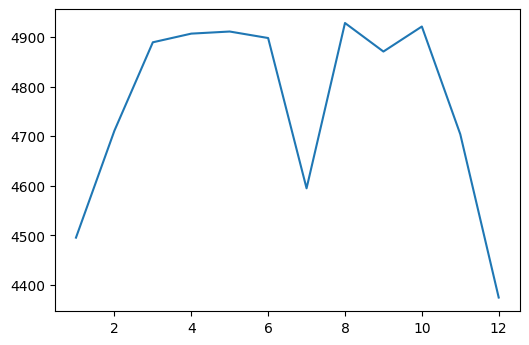

In [14]:
plt.plot(by_month.index, by_month['traffic_volume'])
plt.show()

As we can see, the daytime traffic volume is usually less heavy in cold months. and more intense during warm months - with one interesting exception: July. Is there anything special about July? Is traffic significantly less heavy in July each year? Let's check.

In [15]:
daytime['year'] = daytime['date_time'].dt.year
july_data = daytime[daytime['month'] == 7]
july_data_grouped = july_data.groupby('year').mean()
july_data_grouped.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,month
year,,,,,,
2013,296.796832,0.529838,0.0,24.245946,4914.354054,7.0
2014,296.225777,0.296686,0.0,52.542522,4871.598240,7.0
2015,296.657288,0.457241,0.0,35.301887,4613.146226,7.0
2016,297.018584,24.633670,0.0,52.534483,3924.923645,7.0
2017,297.139799,0.000000,0.0,41.724311,4734.120301,7.0


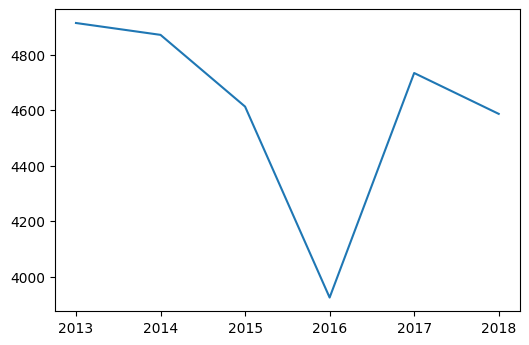

In [16]:
plt.plot(july_data_grouped.index, july_data_grouped['traffic_volume'])
plt.show()

Typically, the traffic is pretty heavy in July, similar to the other warm months. The only exception we see is 2016, which had a high decrease in traffic volume. One possible reason for this is road construction. 

As a tentative conclusion here, we can say that warm months generally show heavier traffic compared to cold months. In a warm month, you can can expect for each hour of daytime a traffic volume close to 5,000 cars.

Now, let's get the traffic volume averages for each day of the week.

In [17]:
daytime['dayofweek'] = daytime['date_time'].dt.dayofweek
by_dayofweek = daytime.groupby('dayofweek').mean()
by_dayofweek['traffic_volume']  # 0 is Monday, 6 is Sunday

dayofweek
0    4893.551286
1    5189.004782
2    5284.454282
3    5311.303730
4    5291.600829
5    3927.249558
6    3436.541789
Name: traffic_volume, dtype: float64

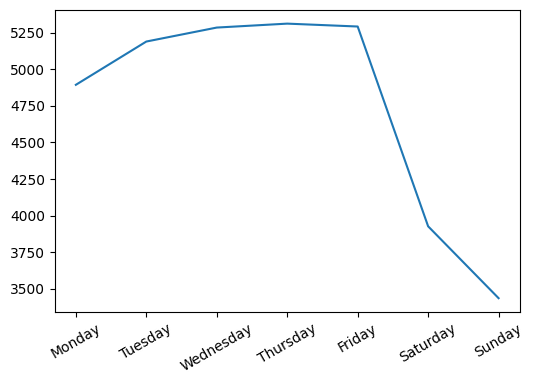

In [18]:
plt.plot(by_dayofweek.index, by_dayofweek['traffic_volume'])
plt.xticks([0,1,2,3,4,5,6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                            'Friday', 'Saturday', 'Sunday'], rotation = 30)
plt.show()

From this figure, we have found that the traffic volume is significantly heavier on business days compared to the weekends.

We'll now generate a line plot for the time of day. The weekends, however, will drag down the average values, so we're going to look at the averages separately. To do that, we'll start by splitting the data based on the day type: business day or weekend.

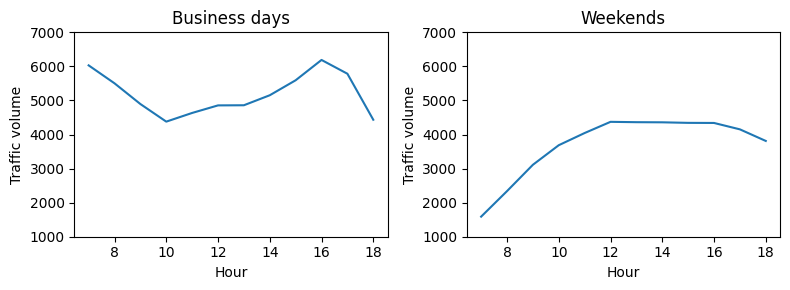

In [19]:
daytime['hour'] = daytime['date_time'].dt.hour
bussiness_days = daytime.copy()[daytime['dayofweek'] <= 4] # 4 == Friday
weekend = daytime.copy()[daytime['dayofweek'] >= 5] # 5 == Saturday
by_hour_business = bussiness_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

plt.figure(figsize = (8,3))
plt.subplot(1, 2, 1)
plt.plot(by_hour_business.index, by_hour_business['traffic_volume'])
plt.title('Business days')
plt.xlabel('Hour')
plt.ylabel('Traffic volume')
plt.ylim([1000, 7000])

plt.subplot(1, 2, 2)
plt.plot(by_hour_weekend.index, by_hour_weekend['traffic_volume'])
plt.title('Weekends')
plt.xlabel('Hour')
plt.ylabel('Traffic volume')
plt.ylim([1000, 7000])

plt.tight_layout()
plt.show()

At each hour of the day, the traffic volume is generally higher during business days compared to the weekends. As somehow expected, the rush hours are around 7 and 16 — when most people travel from home to work and back. We see volumes of over 6,000 cars at rush hours.

To summarize, we found a few time-related indicators of heavy traffic:

* The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
* The traffic is usually heavier on business days compared to weekends.
* On business days, the rush hours are around 7 and 16.

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: temp, rain_1h, snow_1h, clouds_all, weather_main, weather_description.

A few of these columns are numerical, so let's start by looking up their correlation values with traffic_volume.

In [20]:
daytime.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

Temperature shows the strongest correlation with a value of just +0.13. The other relevant columns (rain_1h, snow_1h, clouds_all) don't show any strong correlation with traffic_value.

Let's generate a scatter plot to visualize the correlation between temp and traffic_volume.

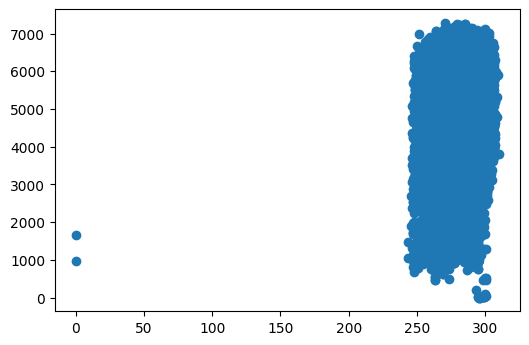

In [21]:
plt.scatter(daytime['temp'], daytime['traffic_volume'])
plt.show()

Obviously, two outliers at 0k need to be removed. Let's generate the scatter plot without the outliers.

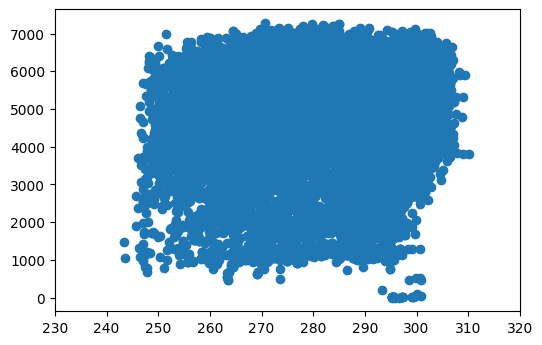

In [22]:
plt.scatter(daytime['temp'], daytime['traffic_volume'])
plt.xlim([230, 320])
plt.show()

We can conclude that temperature doesn't look like a solid indicator of heavy traffic.

Let's now look at the other weather-related columns: weather_main and weather_description.

In [23]:
by_weather_main = daytime.groupby('weather_main').mean()
by_weather_description = daytime.groupby('weather_description').mean()

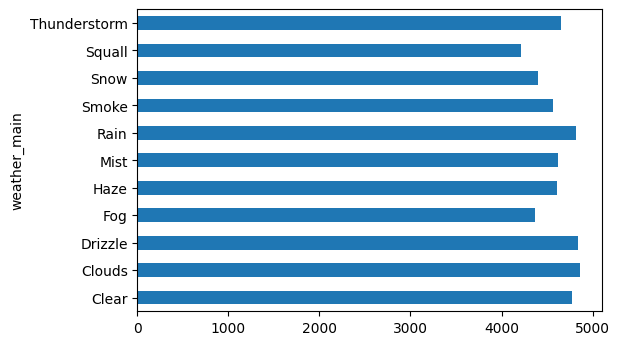

In [24]:
by_weather_main.plot.barh(y='traffic_volume', legend = None)
plt.show()

It looks like there's no weather type where traffic volume exceeds 5,000 cars. This makes finding a heavy traffic indicator more difficult. Let's also group by weather_description, which has a more granular weather classification.

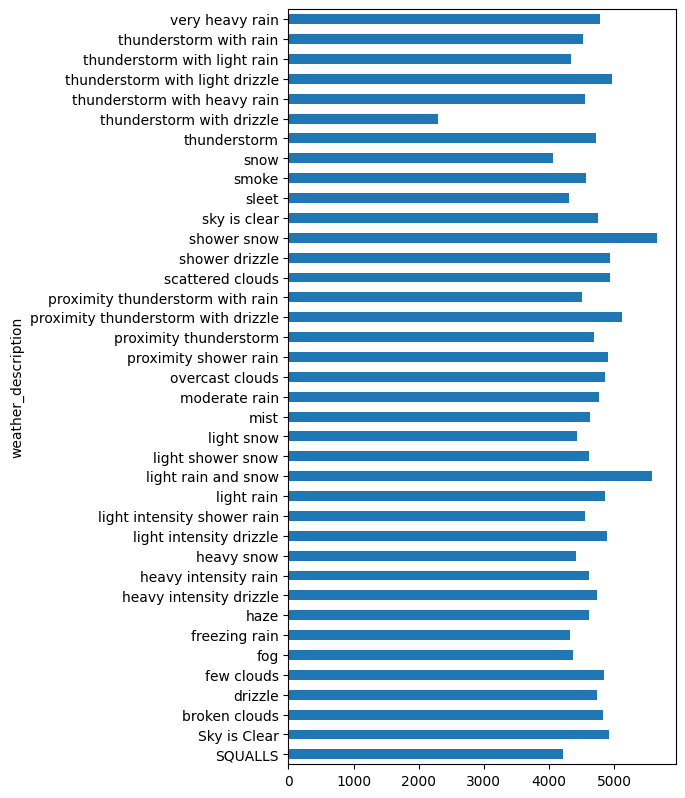

In [25]:
by_weather_description.plot.barh(y='traffic_volume', legend = None,
                           figsize=(5, 10))
plt.show()

It looks like there are three weather types where traffic volume exceeds 5,000:

* Shower snow
* Light rain and snow
* Proximity thunderstorm with drizzle

It's not clear why these weather types have the highest average traffic values — this is bad weather, but not that bad. Perhaps more people take their cars out of the garage when the weather is bad instead of riding a bike or walking.

## Conclusions
In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:

* Time indicators
    * The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
    * The traffic is usually heavier on business days compared to the weekends.
    * On business days, the rush hours are around 7 and 16.
* Weather indicators
    * Shower snow
    * Light rain and snow
    * Proximity thunderstorm with drizzle